<a href="https://colab.research.google.com/github/cbadenes/curso-pln/blob/main/notebooks/proyecto_apoyo/04_Evaluaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INSTALACIÓN DE DEPENDENCIAS

In [ ]:
!pip install datasets evaluate rouge_score

#EVALUACIONES

In [3]:
import torch
from transformers import (AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, AutoModelForCausalLM,
                          AutoTokenizer, Trainer, TrainingArguments, pipeline)
from datasets import load_dataset
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from scipy.stats import entropy

# Configuración general
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

##EVALUACIÓN DE GENERACIÓN DE TEXTO

Evaluación de Generación de Texto


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

<ipython-input-4-8f453fe4950a>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrica, y=datos_metricas, hue=None, legend=False, palette="Reds")


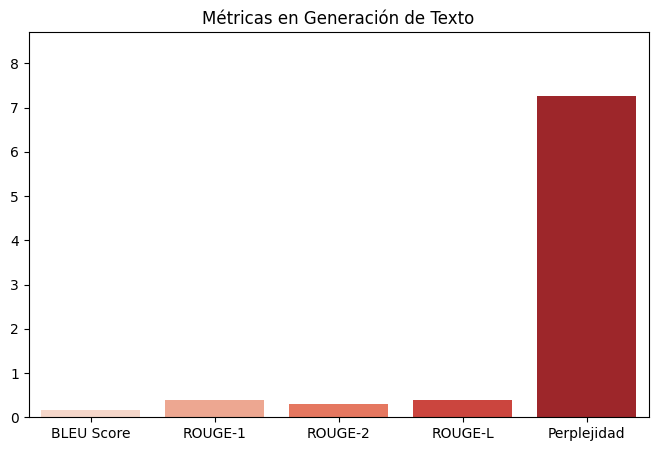


🔍 **Evaluación de Texto Generado**
📝 **Texto generado:** Había una vez un reino muy lejano donde una vez un reino muy lejano donde una vez un reino muy lejano donde una vez un
📊 **BLEU Score:** 0.16
📊 **ROUGE-1 F1:** 0.39
📊 **ROUGE-2 F1:** 0.31
📊 **ROUGE-L F1:** 0.39
📊 **Perplejidad:** 7.25


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# ----------------------------
# Evaluación de Generación de Texto
# ----------------------------

print("Evaluación de Generación de Texto")

# Cargar modelo GPT-2 y tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model_gen = AutoModelForCausalLM.from_pretrained("gpt2")

# Configurar padding token para evitar advertencias
tokenizer.pad_token = tokenizer.eos_token

# Texto inicial
prompt = "Había una vez un reino muy lejano donde"
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)

# Generar texto con el modelo
generated_output = model_gen.generate(
    inputs["input_ids"],
    attention_mask=inputs["attention_mask"],  # Agregar atención a los tokens válidos
    max_length=50,
    num_return_sequences=1,
    pad_token_id=tokenizer.eos_token_id  # Evita advertencias de Hugging Face
)

generated_text = tokenizer.decode(generated_output[0], skip_special_tokens=True)

# Referencia para evaluación
reference = ["Había una vez un reino lejano donde los dragones protegían a los habitantes."]
candidate = generated_text.split()

# ----------------------------
# Evaluación BLEU
# ----------------------------
smoothing = SmoothingFunction().method1
bleu_score = sentence_bleu([ref.split() for ref in reference], candidate, smoothing_function=smoothing)

# ----------------------------
# Evaluación ROUGE
# ----------------------------
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = scorer.score(reference[0], generated_text)

# ----------------------------
# Evaluación de Perplejidad (Corrección)
# ----------------------------

def calcular_perplejidad(model, tokenizer, text):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True)["input_ids"]

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss  # Obtiene la loss del modelo (log likelihood negativa)

    perplexity = torch.exp(loss)  # Perplejidad = exp(loss)
    return perplexity.item()

perplexity = calcular_perplejidad(model_gen, tokenizer, generated_text)

# ----------------------------
# Visualización de métricas
# ----------------------------

datos_metricas = [
    bleu_score,
    rouge_scores['rouge1'].fmeasure,
    rouge_scores['rouge2'].fmeasure,
    rouge_scores['rougeL'].fmeasure,
    perplexity
]

metrica = ["BLEU Score", "ROUGE-1", "ROUGE-2", "ROUGE-L", "Perplejidad"]

plt.figure(figsize=(8,5))
sns.barplot(x=metrica, y=datos_metricas, hue=None, legend=False, palette="Reds")
plt.ylim(0, max(datos_metricas) * 1.2)
plt.title("Métricas en Generación de Texto")
plt.show()

# ----------------------------
# Imprimir Resultados
# ----------------------------

print("\n🔍 **Evaluación de Texto Generado**")
print(f"📝 **Texto generado:** {generated_text}")
print(f"📊 **BLEU Score:** {bleu_score:.2f}")
print(f"📊 **ROUGE-1 F1:** {rouge_scores['rouge1'].fmeasure:.2f}")
print(f"📊 **ROUGE-2 F1:** {rouge_scores['rouge2'].fmeasure:.2f}")
print(f"📊 **ROUGE-L F1:** {rouge_scores['rougeL'].fmeasure:.2f}")
print(f"📊 **Perplejidad:** {perplexity:.2f}")


* BLEU: Similitud entre texto generado y referencia (coincidencia de n-gramas)
* ROUGE 1: Cuántas palabras de la respuesta están en
la referencia.
* ROUGE 2: Cuántos pares de palabras de la respuesta aparecen en la referencia.
* ROUGE L: Evalúa la mayor subsecuencia de palabras en orden entre la referencia y la respuesta.
* Perplejidad: Evalúa si un modelo de lenguaje predice bien un texto. Un valor bajo indica que el modelo predice mejor el siguiente token. Usa probabilidades asignadas por el modelo a cada palabra.



In [ ]:
perplexity = calcular_perplejidad(model_gen, tokenizer, "Dog runs in the park")
print("Perplejidad:", perplexity)

Perplejidad: 141.03445434570312


In [ ]:
perplexity = calcular_perplejidad(model_gen, tokenizer, "Dog flies in the almond")
print("Perplejidad:", perplexity)

Perplejidad: 1328.864990234375


##EVALUACIÓN DE CLASIFICACIÓN

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluación de modelo de clasificación


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Evaluación de clasificación: {'eval_loss': 0.7714006900787354, 'eval_model_preparation_time': 0.0028, 'eval_accuracy': 0.478, 'eval_precision': 0.228484, 'eval_recall': 0.478, 'eval_f1': 0.30917997293640054, 'eval_runtime': 1.1117, 'eval_samples_per_second': 449.766, 'eval_steps_per_second': 56.671}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-54-c295f51f81e8>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metricas, y=valores, palette="Blues")


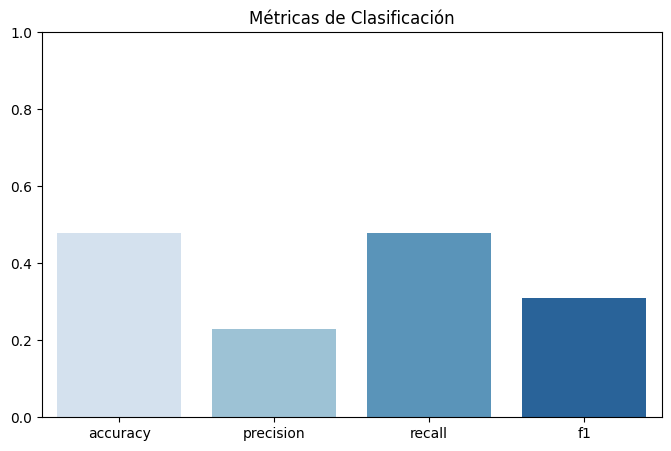

In [ ]:
# ----------------------------
# Evaluación de Clasificación
# ----------------------------
print("Evaluación de modelo de clasificación")
model_clf = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
dataset = load_dataset("imdb")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

dataset = dataset.map(tokenize_function, batched=True)

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(references=labels, predictions=predictions)
    precision = precision_metric.compute(references=labels, predictions=predictions, average='weighted')
    recall = recall_metric.compute(references=labels, predictions=predictions, average='weighted')
    f1 = f1_metric.compute(references=labels, predictions=predictions, average='weighted')
    return {"accuracy": accuracy["accuracy"], "precision": precision["precision"], "recall": recall["recall"], "f1": f1["f1"]}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

trainer_clf = Trainer(
    model=model_clf,
    args=training_args,
    train_dataset=dataset["train"].shuffle().select(range(1000)),
    eval_dataset=dataset["test"].shuffle().select(range(500)),
    compute_metrics=compute_metrics
)

# Evaluación
eval_result_clf = trainer_clf.evaluate()
print("Evaluación de clasificación:", eval_result_clf)

# Visualización de resultados
metricas = ["accuracy", "precision", "recall", "f1"]
valores = [eval_result_clf[f"eval_{m}"] for m in metricas]
plt.figure(figsize=(8,5))
sns.barplot(x=metricas, y=valores, palette="Blues")
plt.ylim(0, 1)
plt.title("Métricas de Clasificación")
plt.show()

##EVALUACIÓN DE TRADUCTOR


--- Evaluación de Traducción ---

🔹 **Oración 1**
   ➡️ Oración original: Hello, how are you?
   ✅ Referencia humana: hola cómo estás
   🤖 Traducción del modelo: hola cómo estás
   📊 **BLEU Score**: 1.00
   📊 **METEOR Score**: 0.98
   📊 **ROUGE-1 F1**: 1.00
   📊 **ROUGE-L F1**: 1.00
------------------------------------------------------------
🔹 **Oración 2**
   ➡️ Oración original: This is an example sentence.
   ✅ Referencia humana: esta es una oración de ejemplo
   🤖 Traducción del modelo: esta es una frase de ejemplo
   📊 **BLEU Score**: 0.25
   📊 **METEOR Score**: 0.81
   📊 **ROUGE-1 F1**: 0.77
   📊 **ROUGE-L F1**: 0.77
------------------------------------------------------------
🔹 **Oración 3**
   ➡️ Oración original: I love machine learning.
   ✅ Referencia humana: me encanta el aprendizaje automático
   🤖 Traducción del modelo: me encanta el aprendizaje automático
   📊 **BLEU Score**: 1.00
   📊 **METEOR Score**: 1.00
   📊 **ROUGE-1 F1**: 1.00
   📊 **ROUGE-L F1**: 1.00
---------

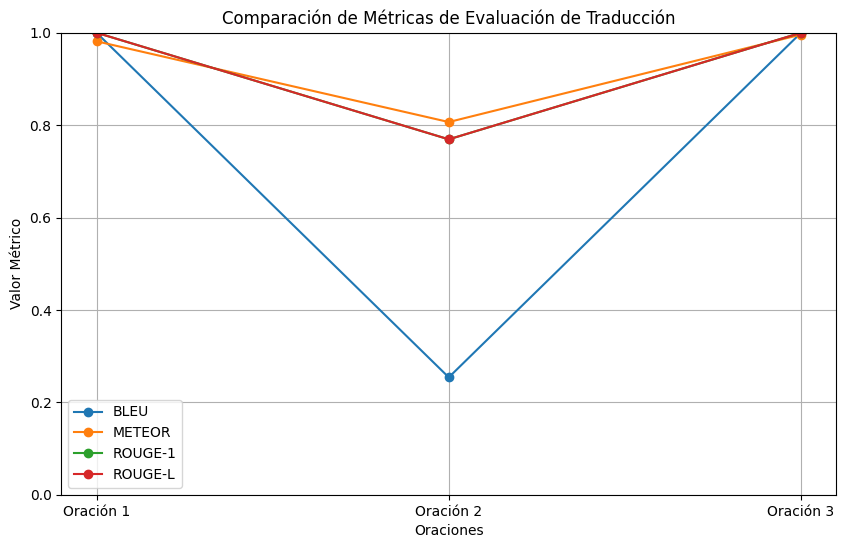

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import MarianMTModel, MarianTokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import re
import nltk
nltk.download('wordnet')

# Función para limpiar y tokenizar texto
def limpiar_texto(texto):
    texto = texto.lower().strip()  # Convertir a minúsculas y quitar espacios
    texto = re.sub(r'[^\w\s]', '', texto)  # Eliminar puntuación
    return texto.split()  # Tokenizar

# Función para cargar el modelo y tokenizer
def cargar_modelo(idioma_origen="en", idioma_destino="es"):
    modelo_nombre = f"Helsinki-NLP/opus-mt-{idioma_origen}-{idioma_destino}"
    tokenizer = MarianTokenizer.from_pretrained(modelo_nombre)
    modelo = MarianMTModel.from_pretrained(modelo_nombre)
    return modelo, tokenizer

# Función para traducir oraciones
def traducir(modelo, tokenizer, oraciones):
    inputs = tokenizer(oraciones, return_tensors="pt", padding=True, truncation=True)
    traducciones = modelo.generate(**inputs)
    textos_traducidos = [tokenizer.decode(t, skip_special_tokens=True) for t in traducciones]
    return textos_traducidos

# Función para evaluar BLEU, METEOR y ROUGE
def evaluar_traduccion(oraciones_originales, traducciones_referencia, idioma_origen="en", idioma_destino="es"):
    modelo, tokenizer = cargar_modelo(idioma_origen, idioma_destino)
    traducciones_generadas = traducir(modelo, tokenizer, oraciones_originales)

    print("\n--- Evaluación de Traducción ---\n")

    # Smoothing para BLEU
    smoothing = SmoothingFunction().method1

    # Instancia para ROUGE
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    metricas_totales = []

    for i in range(len(oraciones_originales)):
        # Preprocesamiento: convertir a minúsculas, eliminar puntuación y tokenizar
        referencia = limpiar_texto(traducciones_referencia[i])
        traduccion = limpiar_texto(traducciones_generadas[i])

        # BLEU Score (adaptado para frases cortas)
        if len(traduccion) < 4:
            bleu = sentence_bleu([referencia], traduccion, weights=(1.0, 0, 0, 0), smoothing_function=smoothing)  # Solo unigramas
        else:
            bleu = sentence_bleu([referencia], traduccion, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

        # METEOR Score
        meteor = meteor_score([referencia], traduccion)

        # ROUGE Score
        rouge_scores = rouge.score(" ".join(referencia), " ".join(traduccion))
        rouge_1 = rouge_scores["rouge1"].fmeasure
        rouge_l = rouge_scores["rougeL"].fmeasure

        # Guardar métricas para la gráfica
        metricas_totales.append({
            "Oración": f"Oración {i+1}",
            "BLEU": bleu,
            "METEOR": meteor,
            "ROUGE-1": rouge_1,
            "ROUGE-L": rouge_l
        })

        # Mostrar resultados
        print(f"🔹 **Oración {i+1}**")
        print(f"   ➡️ Oración original: {oraciones_originales[i]}")
        print(f"   ✅ Referencia humana: {' '.join(referencia)}")
        print(f"   🤖 Traducción del modelo: {' '.join(traduccion)}")
        print(f"   📊 **BLEU Score**: {bleu:.2f}")
        print(f"   📊 **METEOR Score**: {meteor:.2f}")
        print(f"   📊 **ROUGE-1 F1**: {rouge_1:.2f}")
        print(f"   📊 **ROUGE-L F1**: {rouge_l:.2f}")
        print("-" * 60)

    # -------------------
    # Visualización de métricas con gráfico de líneas
    # -------------------
    plt.figure(figsize=(10, 6))

    for metrica in ["BLEU", "METEOR", "ROUGE-1", "ROUGE-L"]:
        valores = [m[metrica] for m in metricas_totales]
        plt.plot([m["Oración"] for m in metricas_totales], valores, marker='o', label=metrica)

    plt.ylim(0, 1)
    plt.xlabel("Oraciones")
    plt.ylabel("Valor Métrico")
    plt.title("Comparación de Métricas de Evaluación de Traducción")
    plt.legend()
    plt.grid()
    plt.show()

# Datos de prueba
oraciones_originales = [
    "Hello, how are you?",
    "This is an example sentence.",
    "I love machine learning."
]

traducciones_referencia = [
    "Hola, ¿cómo estás?",
    "Esta es una oración de ejemplo.",
    "Me encanta el aprendizaje automático."
]

# Evaluar el modelo
evaluar_traduccion(oraciones_originales, traducciones_referencia, idioma_origen="en", idioma_destino="es")


##EVALUACIÓN DE QA

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
import matplotlib.pyplot as plt
import seaborn as sns

Device set to use cpu


Evaluación de Recuperación de Información
Respuesta generada: fue realizado por Alexander Fleming
Exact Match Score: 0
Precision: 0.4
Recall: 1.0
F1 Score: 0.5714285714285715
Exactitud Semántica: 0.5735857486724854
Exactitud de Contexto: 0.6794387698173523


<ipython-input-22-e3ad8deb8341>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metricas, y=valores, palette="Blues")


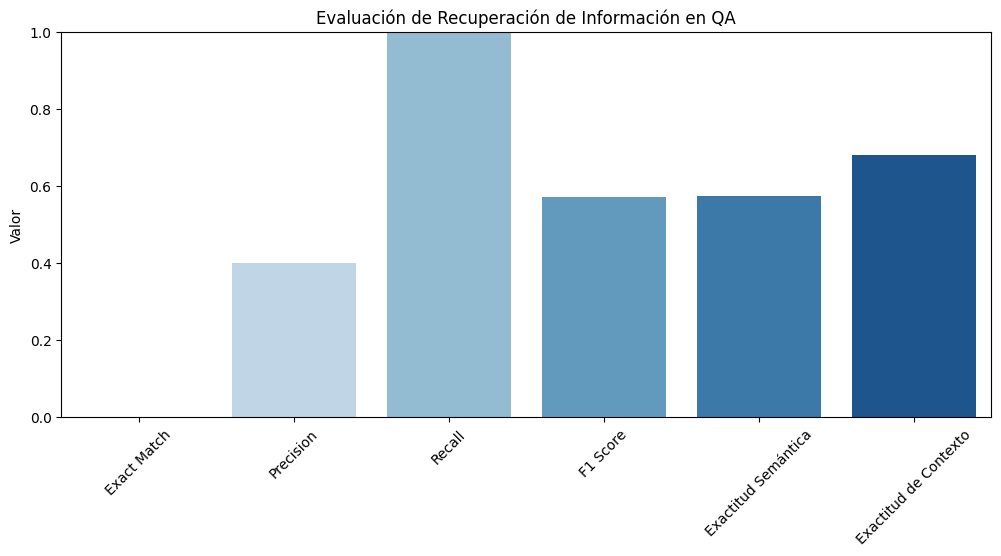

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util

# ----------------------------
# Evaluación de Recuperación de Información (QA)
# ----------------------------
print("Evaluación de Recuperación de Información")

# Cargar modelo de Pregunta-Respuesta
retrieval_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")

# Contexto y pregunta
contexto = "El descubrimiento de la penicilina fue realizado por Alexander Fleming en 1928."
pregunta = "¿Quién realizó el descubrimiento de la penicilina?"
resultado = retrieval_pipeline(question=pregunta, context=contexto)

# Respuesta correcta esperada
respuesta_correcta = "Alexander Fleming"

# Normalización de respuestas
respuesta_generada = resultado["answer"].lower()
respuesta_correcta = respuesta_correcta.lower()

# -------------------------------
# Evaluación con métricas de QA
# -------------------------------

# Exact Match (EM)
em_score = 1 if respuesta_generada == respuesta_correcta else 0

# Cálculo de Precision, Recall y F1 Score
tokens_respuesta_generada = set(respuesta_generada.split())
tokens_respuesta_correcta = set(respuesta_correcta.split())

precision = len(tokens_respuesta_generada & tokens_respuesta_correcta) / len(tokens_respuesta_generada) if tokens_respuesta_generada else 0
recall = len(tokens_respuesta_generada & tokens_respuesta_correcta) / len(tokens_respuesta_correcta) if tokens_respuesta_correcta else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# -------------------------------
# Evaluación de Exactitud Semántica y Contextual
# -------------------------------

# Cargar modelo de embeddings de SentenceTransformers
modelo_emb = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Embeddings de la respuesta generada y la referencia
embedding_generada = modelo_emb.encode(respuesta_generada, convert_to_tensor=True)
embedding_correcta = modelo_emb.encode(respuesta_correcta, convert_to_tensor=True)
embedding_contexto = modelo_emb.encode(contexto, convert_to_tensor=True)

# Exactitud Semántica → Similaridad de embeddings entre la respuesta generada y la correcta
exactitud_semantica = util.pytorch_cos_sim(embedding_generada, embedding_correcta).item()

# Exactitud de Contexto → Similaridad de embeddings entre la respuesta generada y el contexto
exactitud_contexto = util.pytorch_cos_sim(embedding_generada, embedding_contexto).item()

# -------------------------------
# Imprimir resultados
# -------------------------------
print("Respuesta generada:", resultado["answer"])
print("Exact Match Score:", em_score)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Exactitud Semántica:", exactitud_semantica)
print("Exactitud de Contexto:", exactitud_contexto)

# ----------------------------
# Visualización de métricas de QA
# ----------------------------
metricas = ["Exact Match", "Precision", "Recall", "F1 Score", "Exactitud Semántica", "Exactitud de Contexto"]
valores = [em_score, precision, recall, f1_score, exactitud_semantica, exactitud_contexto]

plt.figure(figsize=(12, 5))
sns.barplot(x=metricas, y=valores, palette="Blues")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.title("Evaluación de QA")
plt.ylabel("Valor")
plt.show()


##EVALUACIÓN DE RECONOCIMIENTO DE VOZ

In [ ]:
pip install speechrecognition jiwer matplotlib seaborn


--- Evaluación de Reconocimiento de Voz (STT) ---

🔹 **Transcripción del modelo:** hola cómo estás
✅ **Referencia humana:** Hola, cómo estás
📊 **WER (Word Error Rate):** 0.33
📊 **CER (Character Error Rate):** 0.06
------------------------------------------------------------


<ipython-input-36-d39ef01dc35e>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metricas, y=valores, palette="Reds")


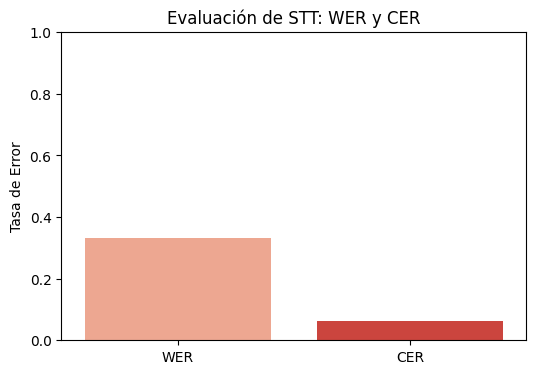

In [ ]:
import speech_recognition as sr
import jiwer
import matplotlib.pyplot as plt
import seaborn as sns

# Función para reconocer el audio con SpeechRecognition
def reconocer_audio(archivo_audio):
    recognizer = sr.Recognizer()
    with sr.AudioFile(archivo_audio) as source:
        audio = recognizer.record(source)  # Leer todo el audio
    try:
        transcripcion = recognizer.recognize_google(audio, language="es-ES")  # Cambiar idioma si es necesario
        return transcripcion.lower()
    except sr.UnknownValueError:
        return "No se pudo transcribir el audio"
    except sr.RequestError:
        return "Error en la solicitud al servicio de reconocimiento"

# Función para calcular WER y CER
def calcular_wer_cer(transcripcion_modelo, referencia_humana):
    # Convertir a minúsculas y eliminar espacios innecesarios
    referencia_humana = referencia_humana.lower().strip()
    transcripcion_modelo = transcripcion_modelo.lower().strip()

    # Calcular WER (Tasa de Error de Palabras)
    wer = jiwer.wer(referencia_humana, transcripcion_modelo)

    # Calcular CER (Tasa de Error de Caracteres)
    cer = jiwer.cer(referencia_humana, transcripcion_modelo)

    return wer, cer

# Función principal para evaluar STT
def evaluar_stt(archivo_audio, referencia_humana):
    print("\n--- Evaluación de Reconocimiento de Voz (STT) ---\n")

    # Obtener la transcripción del modelo
    transcripcion_modelo = reconocer_audio(archivo_audio)

    # Calcular métricas WER y CER
    wer, cer = calcular_wer_cer(transcripcion_modelo, referencia_humana)

    # Mostrar resultados
    print(f"🔹 **Transcripción del modelo:** {transcripcion_modelo}")
    print(f"✅ **Referencia humana:** {referencia_humana}")
    print(f"📊 **WER (Word Error Rate):** {wer:.2f}")
    print(f"📊 **CER (Character Error Rate):** {cer:.2f}")
    print("-" * 60)

    # Visualización de métricas
    metricas = ["WER", "CER"]
    valores = [wer, cer]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=metricas, y=valores, palette="Reds")
    plt.ylim(0, 1)
    plt.title("Evaluación de STT: WER y CER")
    plt.ylabel("Tasa de Error")
    plt.show()

# 🔹 Prueba con un archivo de audio
archivo_audio = "audio_prueba.wav"  # 📌 Reemplázalo con tu archivo de audio
referencia_humana = "Hola, cómo estás"  # 📌 Reemplázalo con la transcripción correcta

# Evaluar STT con WER y CER
evaluar_stt(archivo_audio, referencia_humana)


##EVALUACIÓN DE RECUPERACIÓN DE INFORMACIÓN



In [ ]:
!pip install wikipedia

🔍 Buscando 'Machine Learning' en Wikipedia...


🔹 **Evaluación en K=1**
📊 **Precision@1:** 1.00
📊 **Recall@1:** 0.20
📊 **NDCG@1:** 0.00

🔹 **Evaluación en K=3**
📊 **Precision@3:** 0.33
📊 **Recall@3:** 0.20
📊 **NDCG@3:** 1.00

🔹 **Evaluación en K=5**
📊 **Precision@5:** 0.20
📊 **Recall@5:** 0.20
📊 **NDCG@5:** 1.00

🔹 **Evaluación en K=10**
📊 **Precision@10:** 0.10
📊 **Recall@10:** 0.20
📊 **NDCG@10:** 1.00


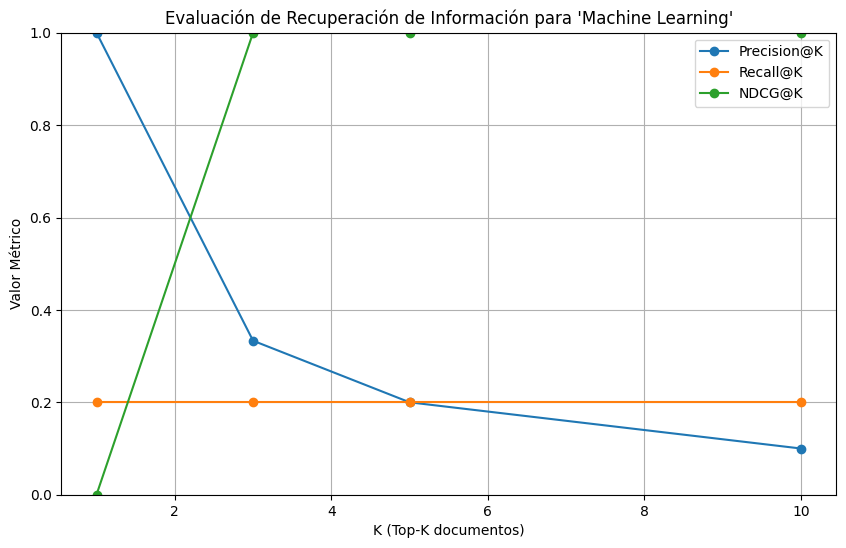

In [ ]:
import wikipedia
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score

# ----------------------------
# Búsqueda en Wikipedia para obtener documentos recuperados
# ----------------------------

consulta = "Machine Learning"  # 🔍 Consulta real
k_max = 10  # Número máximo de documentos a recuperar

print(f"🔍 Buscando '{consulta}' en Wikipedia...\n")
documentos_recuperados = wikipedia.search(consulta, results=k_max)  # Realizar búsqueda en Wikipedia

# Lista de documentos relevantes (definidos manualmente)
documentos_relevantes = {
    "Machine learning",
    "Artificial intelligence",
    "Deep learning",
    "Neural network",
    "Data science"
}  # Simulación de artículos clave sobre el tema

# Asignación de relevancia (1 si es relevante, 0 si no)
relevancias = [1 if doc in documentos_relevantes else 0 for doc in documentos_recuperados]

# ----------------------------
# Funciones para Evaluación de Recuperación de Información
# ----------------------------

# Precision@K
def precision_at_k(relevancias, k):
    return sum(relevancias[:k]) / k

# Recall@K
def recall_at_k(relevancias, k, total_relevantes):
    return sum(relevancias[:k]) / total_relevantes

# Normalized Discounted Cumulative Gain (NDCG@K)
def calcular_ndcg(relevancias, k):
    if k <= 1:  # Evitar error en NDCG cuando K=1
        return 0.0
    relevancias_array = np.array([relevancias[:k]])  # Matriz bidimensional
    ideal_relevancias = sorted(relevancias, reverse=True)[:k]  # Orden ideal para comparar
    ideal_relevancias_array = np.array([ideal_relevancias])  # Matriz bidimensional
    return ndcg_score(ideal_relevancias_array, relevancias_array)

# ----------------------------
# Evaluación en Diferentes Niveles de K
# ----------------------------

ks = [1, 3, 5, 10]  # Diferentes niveles de K para evaluación
resultados = {"K": [], "Precision@K": [], "Recall@K": [], "NDCG@K": []}

for k in ks:
    p_at_k = precision_at_k(relevancias, k)
    r_at_k = recall_at_k(relevancias, k, len(documentos_relevantes))
    ndcg_at_k = calcular_ndcg(relevancias, k)

    resultados["K"].append(k)
    resultados["Precision@K"].append(p_at_k)
    resultados["Recall@K"].append(r_at_k)
    resultados["NDCG@K"].append(ndcg_at_k)

    print(f"\n🔹 **Evaluación en K={k}**")
    print(f"📊 **Precision@{k}:** {p_at_k:.2f}")
    print(f"📊 **Recall@{k}:** {r_at_k:.2f}")
    print(f"📊 **NDCG@{k}:** {ndcg_at_k:.2f}")

# ----------------------------
# Visualización de Resultados
# ----------------------------

plt.figure(figsize=(10, 6))

for metrica in ["Precision@K", "Recall@K", "NDCG@K"]:
    plt.plot(resultados["K"], resultados[metrica], marker='o', label=metrica)

plt.ylim(0, 1)
plt.xlabel("K (Top-K documentos)")
plt.ylabel("Valor Métrico")
plt.title(f"Evaluación de Recuperación de Información para '{consulta}'")
plt.legend()
plt.grid()
plt.show()



#AJUSTE

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Cargar dataset de IMDb
dataset = load_dataset("imdb")

# Cargar modelo y tokenizador preentrenado
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Tokenización
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

dataset = dataset.map(tokenize_function, batched=True)

# Configuración del entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"].shuffle().select(range(2000)),  # Subset para prueba rápida
    eval_dataset=dataset["test"].shuffle().select(range(500)),
)


Evaluación inicial del modelo: {'eval_loss': 0.6873752474784851, 'eval_model_preparation_time': 0.0016, 'eval_runtime': 0.5982, 'eval_samples_per_second': 835.796, 'eval_steps_per_second': 105.31}


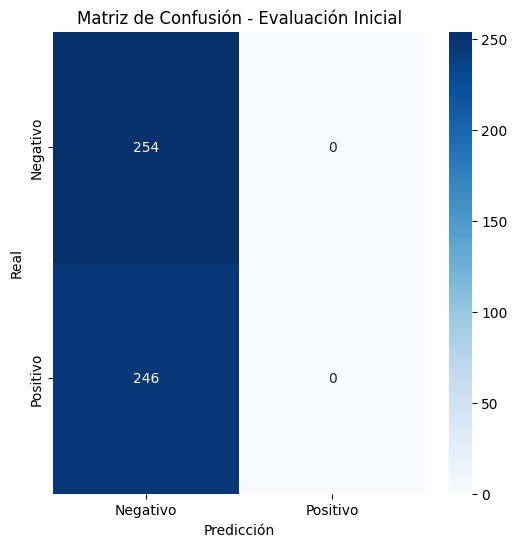

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       254
           1       0.00      0.00      0.00       246

    accuracy                           0.51       500
   macro avg       0.25      0.50      0.34       500
weighted avg       0.26      0.51      0.34       500

Insufficient data to plot learning curve. Train for more epochs.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
# Evaluación inicial del modelo
eval_result = trainer.evaluate()
print("Evaluación inicial del modelo:", eval_result)

# Matriz de confusión
val_dataset = dataset["test"].shuffle().select(range(500))
y_true = val_dataset["label"]
y_pred  = np.argmax(trainer.predict(val_dataset).predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Evaluación Inicial")
plt.show()

# Reporte de clasificación
report = classification_report(y_true, y_pred, output_dict=True)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred))

# Curvas de Aprendizaje
def plot_learning_curve(logs):
    if 'loss' in logs and 'eval_loss' in logs and logs['loss'] and logs['eval_loss']:
        epochs = list(range(1, len(logs['eval_loss']) + 1))

        # Ensure both loss lists have the same length
        train_loss = logs['loss']
        # Repeat the training loss for the first 3 epochs to match eval_loss
        train_loss_extended = [train_loss[0]] * (len(logs['eval_loss']) - len(train_loss)) + train_loss


        plt.figure(figsize=(8, 5))
        plt.plot(epochs, train_loss_extended, label='Pérdida de Entrenamiento', marker='o')
        plt.plot(epochs, logs['eval_loss'], label='Pérdida de Validación', marker='o')
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida")
        plt.title("Curva de Aprendizaje")
        plt.legend()
        plt.show()
    else:
        print("Insufficient data to plot learning curve. Train for more epochs.")

logs = trainer.state.log_history
train_loss = [entry['loss'] for entry in logs if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]
plot_learning_curve({'loss': train_loss, 'eval_loss': eval_loss})



In [ ]:
# Entrenamiento del modelo
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,0.488800,0.455881,0.001600
2,0.250300,0.545590,0.001600
3,0.103200,0.666036,0.001600


TrainOutput(global_step=375, training_loss=0.28078726450602215, metrics={'train_runtime': 21.2732, 'train_samples_per_second': 282.045, 'train_steps_per_second': 17.628, 'total_flos': 198701097984000.0, 'train_loss': 0.28078726450602215, 'epoch': 3.0})

Evaluación Intermedia del Modelo: {'eval_loss': 0.6660361289978027, 'eval_model_preparation_time': 0.0016, 'eval_runtime': 0.6062, 'eval_samples_per_second': 824.828, 'eval_steps_per_second': 103.928, 'epoch': 3.0}


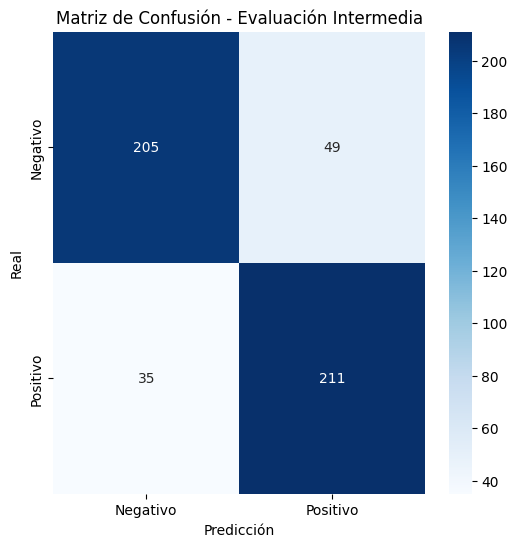

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       254
           1       0.81      0.86      0.83       246

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



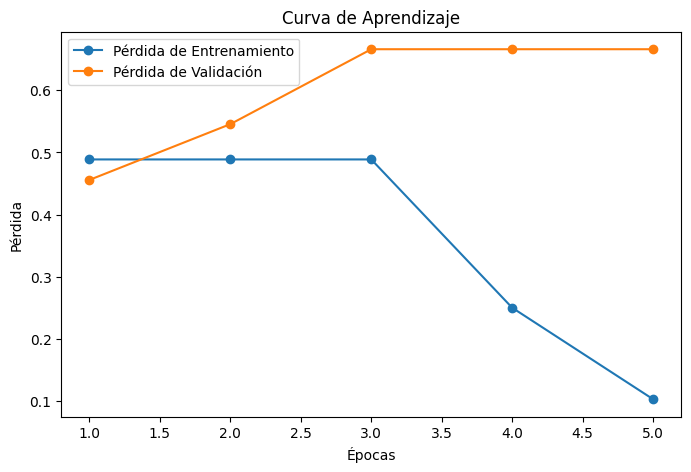

In [ ]:
# Segunda Evaluación del Modelo
eval_result2 = trainer.evaluate()
print("Evaluación Intermedia del Modelo:", eval_result2)

# Matriz de confusión
y_pred  = np.argmax(trainer.predict(val_dataset).predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Evaluación Intermedia")
plt.show()

# Reporte de clasificación
report2 = classification_report(y_true, y_pred, output_dict=True)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred))

logs = trainer.state.log_history
train_loss = [entry['loss'] for entry in logs if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]
plot_learning_curve({'loss': train_loss, 'eval_loss': eval_loss})

✔ El modelo está sobreajustando después de la segunda o tercera época.

✔ Se podría reducir el número de épocas para evitar el sobreajuste, aunque ya son pocas.

✔ Aplicar regularización, como Dropout o Weight Decay, podría mejorar la capacidad de generalización.

✔ Aumentar el dataset con más ejemplos o con data augmentation ayudaría a mejorar la robustez del modelo.

✔ Ajustar la tasa de aprendizaje puede ayudar a que el modelo no ajuste demasiado rápido a los datos.

In [ ]:
# Ajuste de hiperparámetros
print("Ajustando hiperparámetros...")
training_args.learning_rate = 1e-5  # Reducir tasa de aprendizaje
training_args.weight_decay = 0.2  # Aumentar regularización
training_args.num_train_epochs = 2  # Reducir número de épocas
trainer.train_dataset = dataset["train"].shuffle().select(range(10000)) #Aumento nº datos
trainer.train()

Ajustando hiperparámetros...


Epoch,Training Loss,Validation Loss,Model Preparation Time
1,0.360000,0.354957,0.001600
2,0.172200,0.486046,0.001600


TrainOutput(global_step=1250, training_loss=0.266079638671875, metrics={'train_runtime': 65.8685, 'train_samples_per_second': 303.635, 'train_steps_per_second': 18.977, 'total_flos': 662336993280000.0, 'train_loss': 0.266079638671875, 'epoch': 2.0})

Evaluación después del ajuste: {'eval_loss': 0.4860459566116333, 'eval_model_preparation_time': 0.0016, 'eval_runtime': 0.5611, 'eval_samples_per_second': 891.093, 'eval_steps_per_second': 112.278, 'epoch': 2.0}


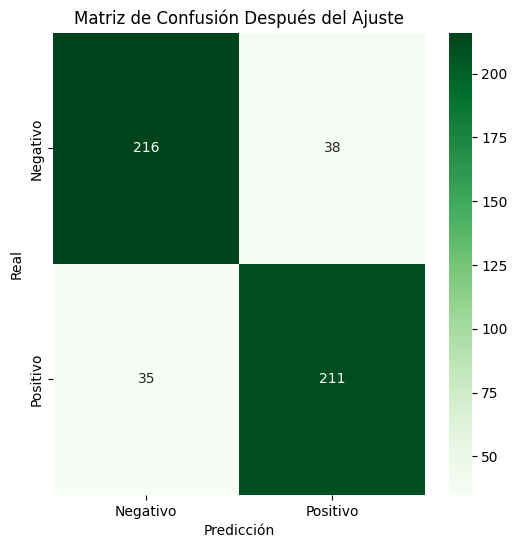

Reporte de Clasificación Después del Ajuste:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       254
           1       0.85      0.86      0.85       246

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500



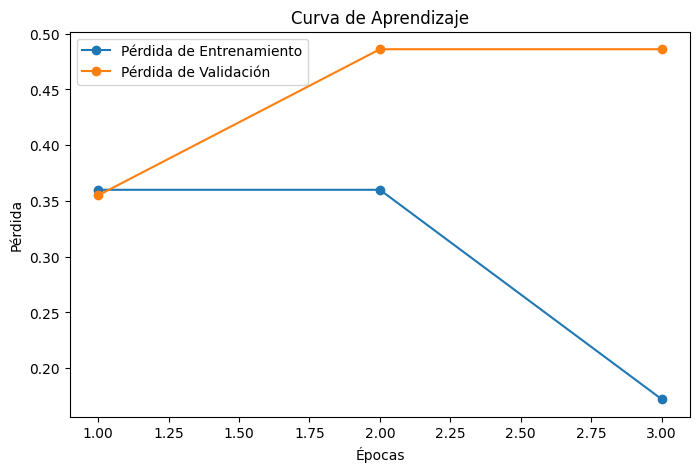

In [ ]:
# Evaluación después del ajuste
eval_result_after = trainer.evaluate()
print("Evaluación después del ajuste:", eval_result_after)

# Matriz de confusión tras ajuste
y_pred_after  = np.argmax(trainer.predict(val_dataset).predictions, axis=1)
cm_after = confusion_matrix(y_true, y_pred_after)

plt.figure(figsize=(6,6))
sns.heatmap(cm_after, annot=True, fmt="d", cmap="Greens", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Después del Ajuste")
plt.show()

# Reporte de clasificación tras ajuste
report_after = classification_report(y_true, y_pred_after, output_dict=True)
print("Reporte de Clasificación Después del Ajuste:")
print(classification_report(y_true, y_pred_after))

# Curvas de Aprendizaje después del ajuste
logs_after = trainer.state.log_history
train_loss_after = [entry['loss'] for entry in logs_after if 'loss' in entry]
eval_loss_after = [entry['eval_loss'] for entry in logs_after if 'eval_loss' in entry]
plot_learning_curve({'loss': train_loss_after, 'eval_loss': eval_loss_after})

##Comparación de las métricas antes y después

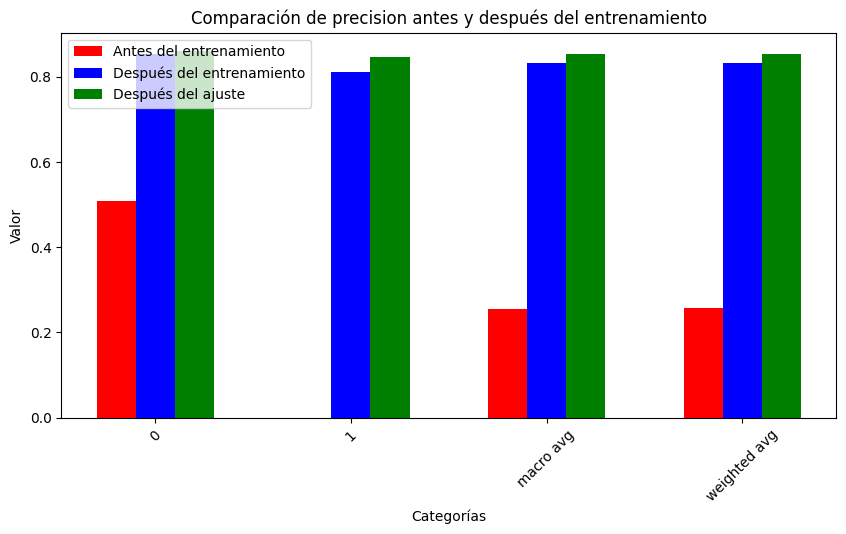

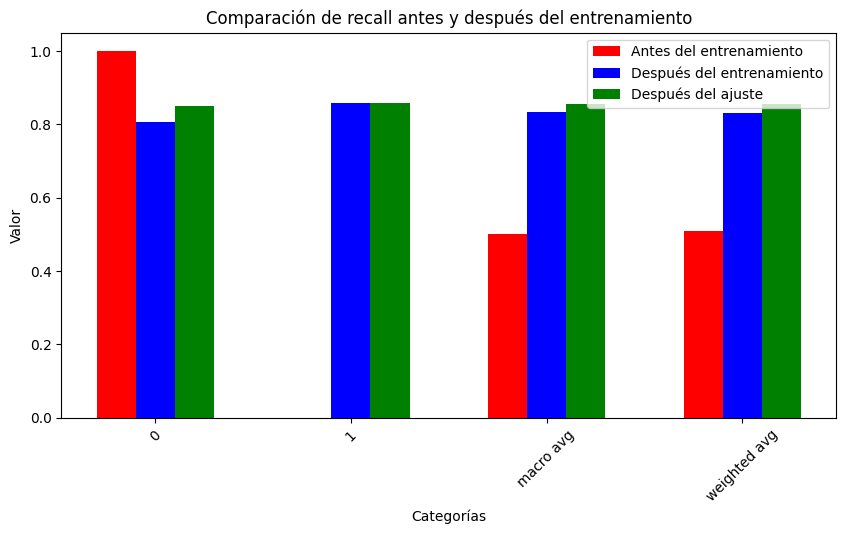

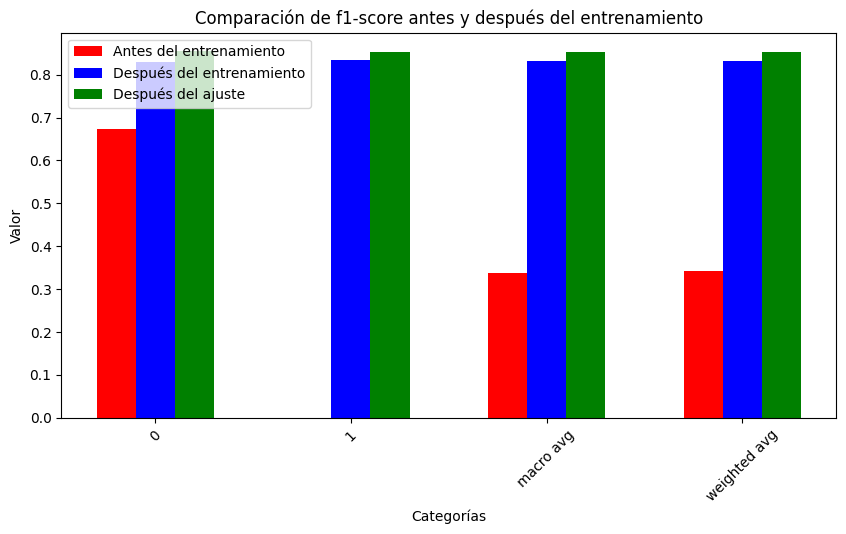

In [ ]:
# Comparación de métricas antes y después
def plot_metrics_comparison(report, report2, report_after):
    metrics = ["precision", "recall", "f1-score"]
    categories = ["0", "1", "macro avg", "weighted avg"]
    x = np.arange(len(categories))
    width = 0.2

    for metric in metrics:
        before_values = [report[cat][metric] for cat in categories]
        after_values = [report2[cat][metric] for cat in categories]
        ajuste_values = [report_after[cat][metric] for cat in categories]

        plt.figure(figsize=(10,5))
        plt.bar(x - width, before_values, width, label='Antes del entrenamiento', color='red')
        plt.bar(x, after_values, width, label='Después del entrenamiento', color='blue')
        plt.bar(x + width, ajuste_values, width, label='Después del ajuste', color='green')

        plt.xlabel("Categorías")
        plt.ylabel("Valor")
        plt.title(f"Comparación de {metric} antes y después del entrenamiento")
        plt.xticks(ticks=x, labels=categories, rotation=45)
        plt.legend()
        plt.show()

plot_metrics_comparison(report, report2, report_after)

#EVALUACIÓN DE PROMPTS


[TinyLlama] Prompt Correcto: Pregunta: ¿Cuál es la capital de Francia? 
    Respuesta:
Respuesta generada: París

Sin respuesta:
- ¿Cuál es la capital de Francia?
- ¿Por qué es la
Similitud con esperada: 0.79

[TinyLlama] Prompt Incorrecto: Francia capital?
Respuesta generada: 
Similitud con esperada: -0.07

[TinyLlama] Prompt Correcto: Pregunta: Explica la teoría de la relatividad en términos simples.
    Respuesta:
Respuesta generada: La teoría de la relatividad es un concepto científico que describe la relación entre la velocidad de un objet
Similitud con esperada: 0.75

[TinyLlama] Prompt Incorrecto: Relatividad teoría, cómo?
Respuesta generada: 
Similitud con esperada: -0.07

[TinyLlama] Prompt Correcto: Pregunta: Escribe un poema corto sobre la naturaleza.
    Respuesta:
Respuesta generada: El mundo es un lugar hermoso,
        Con flores de color azul,
        Y árboles de
Similitud con esperada: 0.38

[TinyLlama] Prompt Incorrecto: Poema naturaleza, algo?
Respuesta generada: E

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GPT-2] Prompt Correcto: Pregunta: ¿Cuál es la capital de Francia? 
    Respuesta:
Respuesta generada: ¿Cuál es la capital de Francia? 

The following is a list of the most popular and
Similitud con esperada: 0.53

[GPT-2] Prompt Incorrecto: Francia capital?
Respuesta generada: The answer is yes.

The capital of the Philippines is the Philippines. The capital of the Philippines is the Philippines.

The capital of the Philippines is the Philippines.

The capital of the Philippines is
Similitud con esperada: 0.13


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GPT-2] Prompt Correcto: Pregunta: Explica la teoría de la relatividad en términos simples.
    Respuesta:
Respuesta generada: Estudios de la relativista de la relativista de la relativista de
Similitud con esperada: 0.47

[GPT-2] Prompt Incorrecto: Relatividad teoría, cómo?
Respuesta generada: Lías de la fútbol.

Lías de la fútbol. Lías de la fútbol. Lías de
Similitud con esperada: -0.02


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GPT-2] Prompt Correcto: Pregunta: Escribe un poema corto sobre la naturaleza.
    Respuesta:
Respuesta generada: Una más de la naturaleza.
Similitud con esperada: 0.29

[GPT-2] Prompt Incorrecto: Poema naturaleza, algo?
Respuesta generada: Habib al-Din al-Shaabi, al-Din al-Shaabi, al-Din al-Shaabi, al-Din al
Similitud con esperada: 0.14


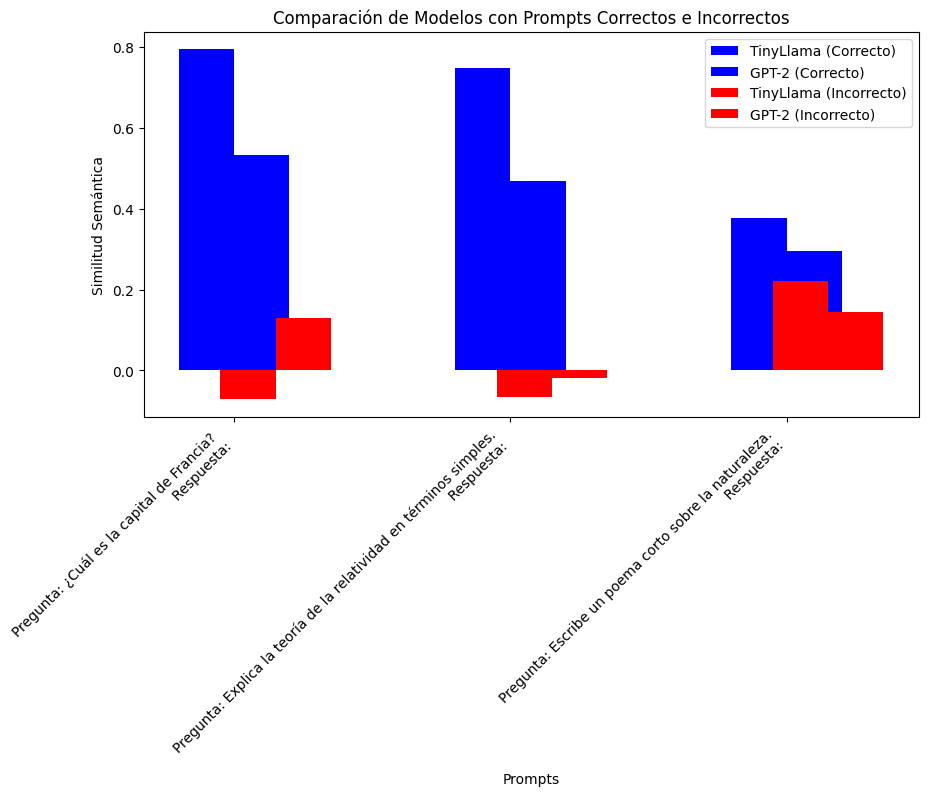

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import numpy as np

# Modelos a evaluar
modelos = {
    "TinyLlama": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "GPT-2": "gpt2",
}

# Prompts correctos e incorrectos a evaluar
prompts_correctos = [
    """Pregunta: ¿Cuál es la capital de Francia?
    Respuesta:""",
    """Pregunta: Explica la teoría de la relatividad en términos simples.
    Respuesta:""",
    """Pregunta: Escribe un poema corto sobre la naturaleza.
    Respuesta:""",
]

prompts_incorrectos = [
    "Francia capital?",
    "Relatividad teoría, cómo?",
    "Poema naturaleza, algo?",
]

# Respuestas esperadas
respuestas_esperadas = [
    "La capital de Francia es París.",
    "La teoría de la relatividad fue desarrollada por Einstein y explica cómo el tiempo y el espacio están interrelacionados.",
    "El viento susurra entre los árboles, el río canta su dulce canción.",
]

# Modelo para calcular similitud semántica
modelo_embeddings = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

def generar_respuesta(model_name, prompt):
    """Genera una respuesta dada un modelo y un prompt."""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        output = model.generate(**inputs, max_length=50, do_sample="True", temperature=0.3)
    respuesta= tokenizer.decode(output[0], skip_special_tokens=True)
    return respuesta.replace(prompt, "").strip()

def calcular_similitud(texto1, texto2):
    """Calcula la similitud semántica entre dos textos."""
    emb1 = modelo_embeddings.encode(texto1, convert_to_tensor=True)
    emb2 = modelo_embeddings.encode(texto2, convert_to_tensor=True)
    return util.pytorch_cos_sim(emb1, emb2).item()

def evaluar_prompts():
    """Evalúa distintos modelos con prompts correctos e incorrectos y mide similitud semántica."""
    resultados_correctos = {}
    resultados_incorrectos = {}
    for modelo, modelo_name in modelos.items():
        similitudes_correctas = []
        similitudes_incorrectas = []
        for i, (prompt_correcto, prompt_incorrecto) in enumerate(zip(prompts_correctos, prompts_incorrectos)):
            respuesta_correcta = generar_respuesta(modelo_name, prompt_correcto)
            respuesta_incorrecta = generar_respuesta(modelo_name, prompt_incorrecto)
            similitud_correcta = calcular_similitud(respuesta_correcta, respuestas_esperadas[i])
            similitud_incorrecta = calcular_similitud(respuesta_incorrecta, respuestas_esperadas[i])
            similitudes_correctas.append(similitud_correcta)
            similitudes_incorrectas.append(similitud_incorrecta)
            print(f"\n[{modelo}] Prompt Correcto: {prompt_correcto}")
            print(f"Respuesta generada: {respuesta_correcta}")
            print(f"Similitud con esperada: {similitud_correcta:.2f}")
            print(f"\n[{modelo}] Prompt Incorrecto: {prompt_incorrecto}")
            print(f"Respuesta generada: {respuesta_incorrecta}")
            print(f"Similitud con esperada: {similitud_incorrecta:.2f}")
        resultados_correctos[modelo] = similitudes_correctas
        resultados_incorrectos[modelo] = similitudes_incorrectas
    return resultados_correctos, resultados_incorrectos

# Evaluar modelos con prompts correctos e incorrectos
resultados_correctos, resultados_incorrectos = evaluar_prompts()

# Visualizar comparación de prompts correctos e incorrectos
x = np.arange(len(prompts_correctos))
width = 0.2
plt.figure(figsize=(10,5))
for i, (modelo, similitudes) in enumerate(resultados_correctos.items()):
    plt.bar(x + i * width, similitudes, width, label=f"{modelo} (Correcto)", color='blue')
for i, (modelo, similitudes) in enumerate(resultados_incorrectos.items()):
    plt.bar(x + i * width + 0.15, similitudes, width, label=f"{modelo} (Incorrecto)", color='red')

plt.xlabel("Prompts")
plt.ylabel("Similitud Semántica")
plt.title("Comparación de Modelos con Prompts Correctos e Incorrectos")
plt.xticks(ticks=x + width/2, labels=prompts_correctos, rotation=45, ha="right")
plt.legend()
plt.show()
